In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler


from matplotlib.backends.backend_pdf import PdfPages
from google.colab import files
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Flatten, Conv1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import LeakyReLU


# Functions

In [ ]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)

In [ ]:
def create_dataset(dataset, look_back=1, response_variable_index=0, multi_feature = True):
  dataX, dataY = [], []
  if multi_feature :
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back)]
      dataX.append(a)
      dataY.append(dataset[i + look_back, response_variable_index])
  else:
    for i in range(len(dataset)-look_back -1):
      a = dataset[i:(i+look_back-1),response_variable_index]
      dataX.append(a)
      dataY.append(dataset[i + look_back, response_variable_index])
  return np.array(dataX), np.array(dataY)

In [ ]:
def prepare(df, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8):
  df = df.astype("float32")
  scaler = MinMaxScaler(feature_range=scaling_range)
  dataset = scaler.fit_transform(df)
  X, Y = create_dataset(dataset, time_step, response_variable_index, multi_feature = True)
  # split into train and test sets
  train_size = int(len(dataset) * data_split_ratio)
  test_size = len(dataset) - train_size
  trainX, testX = X[0:train_size,:], X[train_size:len(dataset),:]
  trainY, testY = Y[0:train_size], Y[train_size:len(dataset)]
  #print(trainX.shape)
  #print(testX.shape)
  # reshape input to be [samples, time steps, features]
  if not multi_feature:
    trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1],1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1))
    #print(trainX.shape)
  X_train=trainX
  X_test=testX
  y_train=trainY.reshape(-1,1)
  y_test=testY.reshape(-1,1)
  return X_train,X_test, y_train, y_test

In [ ]:
def model_cnn():
  model_cnn = Sequential()
  model_cnn.add(Conv1D(filters=16,
        kernel_size=3,
        input_shape=(X_train.shape[1], X_train.shape[2])
            )
                  )
  model_cnn.add(LeakyReLU(alpha=0.1))
  model_cnn.add(MaxPooling1D(pool_size=1))
  model_cnn.add(Dropout(rate=0.2))
  model_cnn.add(Flatten())
  model_cnn.add(Dense(1))
  model_cnn.compile(loss='mae', optimizer='adam')
  return model_cnn

In [ ]:
def model_lstm():
  model_lstm = Sequential()
  model_lstm.add(LSTM(16, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
  model_lstm.add(LSTM(units=16))
  model_lstm.add(Dense(units=1))
  model_lstm.compile(loss='mae', optimizer='adam')
  return model_lstm
  #model_lstm.summary()

In [ ]:
def model_gru():
  model_gru = Sequential()
  model_gru.add(GRU(16, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
  model_gru.add(GRU(units=16))
  model_gru.add(Dense(units=1))
  model_gru.compile(loss='mae', optimizer='adam')
  return model_gru

In [ ]:
def model_mlp():
  model_mlp = Sequential()
  model_mlp.add(Flatten(input_shape = (X_train.shape[1], X_train.shape[2])))
  model_mlp.add(Dense(16, activation = "relu"))
  model_mlp.add(Dense(16, activation = "relu"))
  model_mlp.compile(loss='mae', optimizer='adam')
  return model_mlp

In [ ]:
def fit(model, X_train, X_test, y_train, y_test):
  history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor= "val_loss", patience=10)], shuffle=False)
  return history


In [ ]:
def predict(model, y_test):
  y_test_pre = model.predict(X_test)
  return y_test_pre

In [ ]:
def visualize(y_test, y_pre, title):
  results = pd.DataFrame()
  #results['Date']= date_test.reset_index().Date.iloc[1:-1]
  #results["Date"] = date_test
  results["predicted"]=[i[0] for i in y_pre][1:] 
  results["true"] = y_test[:-1]
  #results = results.set_index(["Date"])
  #results.head()
  pyplot.plot(results["predicted"], label='predicted', color='red')
  pyplot.plot(results["true"], label='true', color= 'green')
  pyplot.legend()
  pyplot.title(title)
  pyplot.show()

In [ ]:
def evaluate(y_test, y_pre):
  true = y_test[:-1]
  predicted = [i[0] for i in y_pre][1:]
  rmse = np.sqrt(mean_squared_error(true, predicted))
  mae = mean_absolute_error(true, predicted)
  #print(len(true))
  #print(len(predicted))
  return rmse, mae


#Import Data

In [ ]:
# Maharashtra
df_Ma = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Maharashtra.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])
# Karnataka
df_Ka = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Karnataka.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])
# Kerala
df_Ke = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Kerala.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])
# Tamil Nadu
df_TN = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Tamil-Nadu.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])
# Uttar Pradesh
df_UP = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Uttar-Pradesh.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])



In [ ]:
df_Ma = df_Ma[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]
df_Ka = df_Ka[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]
df_Ke = df_Ke[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]
df_TN = df_TN[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]
df_UP = df_UP[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]

In [ ]:
df_Ma = df_Ma[(df_Ma["Date"] > "2020-03-09") & (df_Ma["Date"] < "2020-06-18")]
df_Ka = df_Ka[(df_Ka["Date"] > "2020-03-09") & (df_Ka["Date"] < "2020-06-18")]
df_Ke = df_Ke[(df_Ke["Date"] > "2020-03-09") & (df_Ke["Date"] < "2020-06-18")]
df_TN = df_TN[(df_TN["Date"] > "2020-03-09") & (df_TN["Date"] < "2020-06-18")]
df_UP = df_UP[(df_UP["Date"] > "2020-03-09") & (df_UP["Date"] < "2020-06-18")]

In [ ]:
df_Ma.shape

(100, 7)

In [ ]:
df_Ma = df_Ma.set_index("Date")
df_Ka = df_Ka.set_index("Date")
df_Ke = df_Ke.set_index("Date")
df_TN = df_TN.set_index("Date")
df_UP = df_UP.set_index("Date")


In [ ]:
RMSE_lstm = []
MAE_lstm = []
RMSE_gru = []
MAE_gru = []
RMSE_mlp = []
MAE_mlp = []
RMSE_cnn = []
MAE_cnn = []
states = ["Maharashtra", "Karnataka", "Kerala", "Tamil Nadu", "Uttar Pradesh"]

# Maharashtra

In [ ]:
X_train,X_test, y_train, y_test = prepare(df_Ma, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

X_train.shape (80, 5, 6)
X_test.shape (14, 5, 6)
y_train.shape (80, 1)
y_test.shape (14, 1)


In [ ]:
model_CNN = model_cnn()
fit(model_CNN, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 15s 113ms/step - loss: 0.0509 - val_loss: 0.5480
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0449 - val_loss: 0.4592
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0399 - val_loss: 0.3692
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0316 - val_loss: 0.2823
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0262 - val_loss: 0.2036
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0241 - val_loss: 0.1399
Epoch 7/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0232 - val_loss: 0.0864
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0207 - val_loss: 0.0515
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0175 - val_loss: 0.0431
Epoch 10/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0171 - val_loss: 0.0484
Epoch 11/100
5/5 [========

CNN RESULTS
RMSE =  0.049744766
MAE =  0.03917126


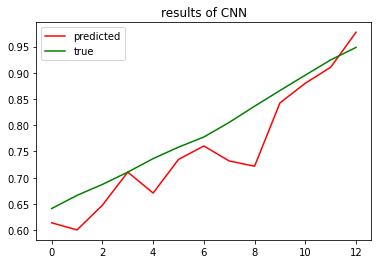

In [ ]:
y_test_pre_cnn = predict(model_CNN, y_test)
print("CNN RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn)
RMSE_cnn.append(rmse)
MAE_cnn.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn, "results of CNN")

In [ ]:
model_MLP = model_mlp()
fit(model_MLP, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 1s 49ms/step - loss: 0.0560 - val_loss: 0.7296
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0557 - val_loss: 0.7181
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0536 - val_loss: 0.6996
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0518 - val_loss: 0.6778
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0501 - val_loss: 0.6510
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0485 - val_loss: 0.6236
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0473 - val_loss: 0.6010
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0464 - val_loss: 0.5833
Epoch 9/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0456 - val_loss: 0.5692
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0448 - val_loss: 0.5591
Epoch 11/100
5/5 [==========

In [ ]:
model_MLP.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
Total params: 768
Trainable params: 768
Non-trainable params: 0
_________________________________________________________________


MLP RESULTS
RMSE =  0.7946809
MAE =  0.78880364


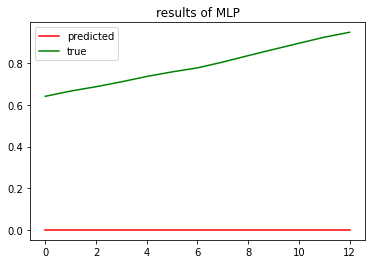

In [ ]:
y_test_pre_mlp = predict(model_MLP, y_test)
print("MLP RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_mlp)
RMSE_mlp.append(rmse)
MAE_mlp.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_mlp, "results of MLP")

In [ ]:
model_LSTM = model_lstm()
fit(model_LSTM, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 10s 214ms/step - loss: 0.0570 - val_loss: 0.7519
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0614 - val_loss: 0.7154
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0642 - val_loss: 0.6830
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0653 - val_loss: 0.6513
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0653 - val_loss: 0.6181
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0645 - val_loss: 0.5829
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0627 - val_loss: 0.5447
Epoch 8/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0599 - val_loss: 0.5011
Epoch 9/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0564 - val_loss: 0.4514
Epoch 10/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0519 - val_loss: 0.3932
Epoch 11/100
5/5 [========

In [ ]:
model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 16)             1472      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,601
Trainable params: 3,601
Non-trainable params: 0
_________________________________________________________________


LSTM RESULTS
RMSE =  0.042885695
MAE =  0.04086044


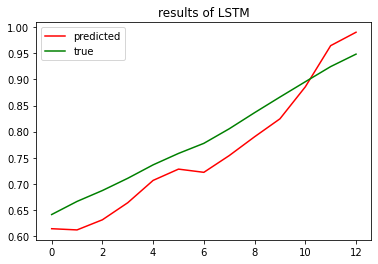

In [ ]:
y_test_pre_lstm = predict(model_LSTM, y_test)
print("LSTM RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_lstm)
RMSE_lstm.append(rmse)
MAE_lstm.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_lstm, "results of LSTM")


In [ ]:
model_GRU = model_gru()
fit(model_GRU, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 5s 188ms/step - loss: 0.0472 - val_loss: 0.6939
Epoch 2/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0604 - val_loss: 0.6531
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0654 - val_loss: 0.6232
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0655 - val_loss: 0.5989
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0626 - val_loss: 0.5770
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0575 - val_loss: 0.5556
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0509 - val_loss: 0.5326
Epoch 8/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0435 - val_loss: 0.5063
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0357 - val_loss: 0.4760
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0275 - val_loss: 0.4400
Epoch 11/100
5/5 [========

In [ ]:
model_GRU.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5, 16)             1152      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 2,801
Trainable params: 2,801
Non-trainable params: 0
_________________________________________________________________


GRU RESULTS
RMSE =  0.09999472
MAE =  0.098979935


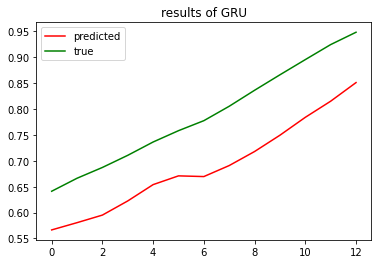

In [ ]:
y_test_pre_gru = predict(model_GRU, y_test)
print("GRU RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_gru)
RMSE_gru.append(rmse)
MAE_gru.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_gru, "results of GRU")



# Karnataka


In [ ]:
X_train,X_test, y_train, y_test = prepare(df_Ka, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
model_CNN = model_cnn()
fit(model_CNN, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 1s 58ms/step - loss: 0.0852 - val_loss: 1.0153
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0688 - val_loss: 0.9270
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0595 - val_loss: 0.8412
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0527 - val_loss: 0.7588
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0522 - val_loss: 0.6808
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0457 - val_loss: 0.6079
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0471 - val_loss: 0.5404
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0453 - val_loss: 0.4794
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0449 - val_loss: 0.4272
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0438 - val_loss: 0.3798
Epoch 11/100
5/5 [=========

CNN RESULTS
RMSE =  0.09050637
MAE =  0.07521052


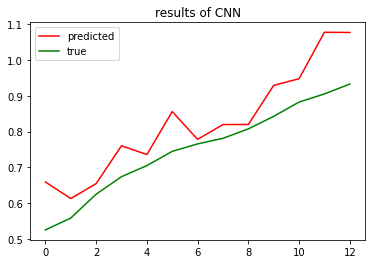

In [ ]:
y_test_pre_cnn = predict(model_CNN, y_test)
print("CNN RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn)
RMSE_cnn.append(rmse)
MAE_cnn.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn, "results of CNN")

In [ ]:
model_MLP = model_mlp()
fit(model_MLP, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 1s 44ms/step - loss: 0.0385 - val_loss: 0.5558
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0363 - val_loss: 0.5618
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0350 - val_loss: 0.5598
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0342 - val_loss: 0.5517
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0336 - val_loss: 0.5392
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0331 - val_loss: 0.5255
Epoch 7/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0325 - val_loss: 0.5120
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0319 - val_loss: 0.4993
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0313 - val_loss: 0.4871
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0306 - val_loss: 0.4760
Epoch 11/100
5/5 [==========

MLP RESULTS
RMSE =  0.05667894
MAE =  0.04147262


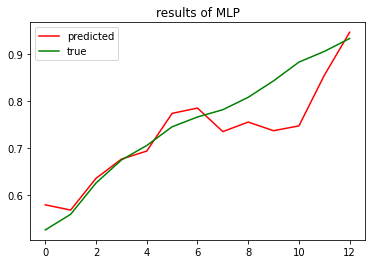

In [ ]:
y_test_pre_mlp = predict(model_MLP, y_test)
print("MLP RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_mlp)
RMSE_mlp.append(rmse)
MAE_mlp.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_mlp, "results of MLP")

In [ ]:
model_LSTM = model_lstm()
fit(model_LSTM, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 3s 214ms/step - loss: 0.0490 - val_loss: 0.8109
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0441 - val_loss: 0.7711
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0472 - val_loss: 0.7395
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0500 - val_loss: 0.7147
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0524 - val_loss: 0.6959
Epoch 6/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0529 - val_loss: 0.6814
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0518 - val_loss: 0.6691
Epoch 8/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0495 - val_loss: 0.6569
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0468 - val_loss: 0.6436
Epoch 10/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0438 - val_loss: 0.6287
Epoch 11/100
5/5 [=========

LSTM RESULTS
RMSE =  0.2655313
MAE =  0.23874329


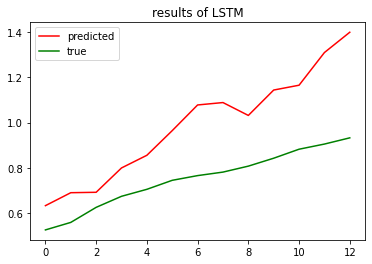

In [ ]:
y_test_pre_lstm = predict(model_LSTM, y_test)
print("LSTM RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_lstm)
RMSE_lstm.append(rmse)
MAE_lstm.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_lstm, "results of LSTM")

In [ ]:
model_GRU = model_gru()
fit(model_GRU, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 3s 194ms/step - loss: 0.0185 - val_loss: 0.3723
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0248 - val_loss: 0.3283
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0230 - val_loss: 0.3198
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0119 - val_loss: 0.3054
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0126 - val_loss: 0.2670
Epoch 6/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0115 - val_loss: 0.2293
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.2129
Epoch 8/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0105 - val_loss: 0.2013
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0111 - val_loss: 0.1885
Epoch 10/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.1766
Epoch 11/100
5/5 [=========

GRU RESULTS
RMSE =  0.035919055
MAE =  0.033188287


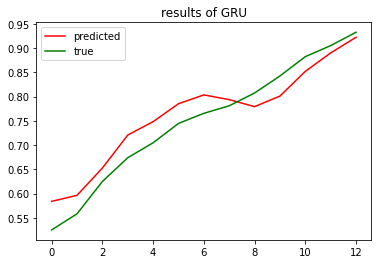

In [ ]:
y_test_pre_gru = predict(model_GRU, y_test)
print("GRU RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_gru)
RMSE_gru.append(rmse)
MAE_gru.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_gru, "results of GRU")


# Kerala

In [ ]:
X_train,X_test, y_train, y_test = prepare(df_Ke, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
model_CNN = model_cnn()
fit(model_CNN, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 1s 62ms/step - loss: 0.1446 - val_loss: 0.9386
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.1097 - val_loss: 0.8227
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0974 - val_loss: 0.7081
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0747 - val_loss: 0.5935
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0655 - val_loss: 0.4825
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0621 - val_loss: 0.3780
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0598 - val_loss: 0.2963
Epoch 8/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0576 - val_loss: 0.2369
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0568 - val_loss: 0.2096
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0546 - val_loss: 0.2014
Epoch 11/100
5/5 [==========

CNN RESULTS
RMSE =  0.038239107
MAE =  0.032763522


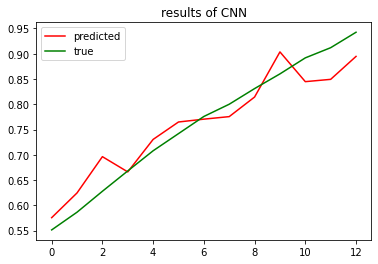

In [ ]:
y_test_pre_cnn = predict(model_CNN, y_test)
print("CNN RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn)
RMSE_cnn.append(rmse)
MAE_cnn.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn, "results of CNN")

In [ ]:
model_MLP = model_mlp()
fit(model_MLP, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 1s 49ms/step - loss: 0.0850 - val_loss: 0.6043
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0809 - val_loss: 0.5809
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0773 - val_loss: 0.5569
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0742 - val_loss: 0.5340
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0714 - val_loss: 0.5124
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0690 - val_loss: 0.4924
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0671 - val_loss: 0.4749
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0653 - val_loss: 0.4587
Epoch 9/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0637 - val_loss: 0.4440
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0623 - val_loss: 0.4301
Epoch 11/100
5/5 [========

MLP RESULTS
RMSE =  0.04609532
MAE =  0.041411243


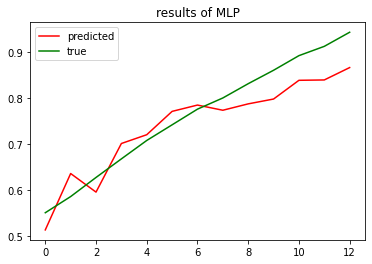

In [ ]:
y_test_pre_mlp = predict(model_MLP, y_test)
print("MLP RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_mlp)
RMSE_mlp.append(rmse)
MAE_mlp.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_mlp, "results of MLP")

In [ ]:
model_LSTM = model_lstm()
fit(model_LSTM, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 3s 202ms/step - loss: 0.1130 - val_loss: 0.7734
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0935 - val_loss: 0.7314
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0792 - val_loss: 0.6886
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0683 - val_loss: 0.6431
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0605 - val_loss: 0.5932
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0564 - val_loss: 0.5385
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0620 - val_loss: 0.4913
Epoch 8/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0722 - val_loss: 0.4672
Epoch 9/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0745 - val_loss: 0.4679
Epoch 10/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0683 - val_loss: 0.4754
Epoch 11/100
5/5 [========

LSTM RESULTS
RMSE =  0.090673305
MAE =  0.08324918


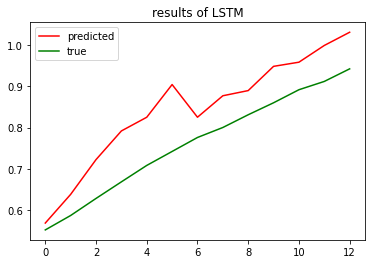

In [ ]:
y_test_pre_lstm = predict(model_LSTM, y_test)
print("LSTM RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_lstm)
RMSE_lstm.append(rmse)
MAE_lstm.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_lstm, "results of LSTM")

In [ ]:
model_GRU = model_gru()
fit(model_GRU, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 3s 190ms/step - loss: 0.0330 - val_loss: 0.2219
Epoch 2/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0483 - val_loss: 0.1754
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0498 - val_loss: 0.1914
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0337 - val_loss: 0.1954
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0253 - val_loss: 0.1675
Epoch 6/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0209 - val_loss: 0.1233
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0228 - val_loss: 0.0977
Epoch 8/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0186 - val_loss: 0.0960
Epoch 9/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0139 - val_loss: 0.0733
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0125 - val_loss: 0.0582
Epoch 11/100
5/5 [========

GRU RESULTS
RMSE =  0.050555658
MAE =  0.0458404


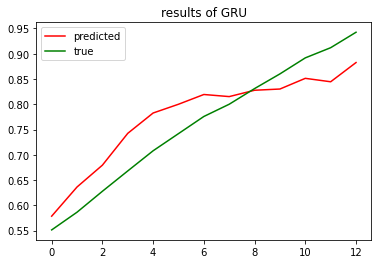

In [ ]:
y_test_pre_gru = predict(model_GRU, y_test)
print("GRU RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_gru)
RMSE_gru.append(rmse)
MAE_gru.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_gru, "results of GRU")


# Tamil Nadu



In [ ]:
X_train,X_test, y_train, y_test = prepare(df_TN, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
model_CNN = model_cnn()
fit(model_CNN, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 1s 65ms/step - loss: 0.0326 - val_loss: 0.5332
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0262 - val_loss: 0.4206
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0247 - val_loss: 0.3229
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0226 - val_loss: 0.2331
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0230 - val_loss: 0.1606
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0173 - val_loss: 0.1163
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0151 - val_loss: 0.1115
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0160 - val_loss: 0.0889
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0180 - val_loss: 0.0913
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0135 - val_loss: 0.1173
Epoch 11/100
5/5 [==========

CNN RESULTS
RMSE =  0.08631824
MAE =  0.07687096


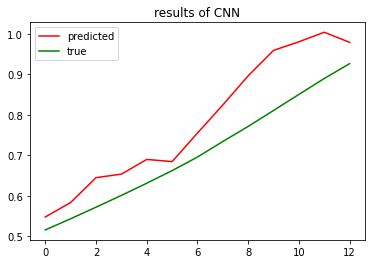

In [ ]:
y_test_pre_cnn = predict(model_CNN, y_test)
print("CNN RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn)
RMSE_cnn.append(rmse)
MAE_cnn.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn, "results of CNN")

In [ ]:
model_MLP = model_mlp()
fit(model_MLP, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 1s 51ms/step - loss: 0.0305 - val_loss: 0.4457
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0300 - val_loss: 0.4124
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0292 - val_loss: 0.3865
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0282 - val_loss: 0.3662
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0272 - val_loss: 0.3471
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0262 - val_loss: 0.3259
Epoch 7/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0251 - val_loss: 0.3029
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0240 - val_loss: 0.2802
Epoch 9/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0229 - val_loss: 0.2598
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0219 - val_loss: 0.2412
Epoch 11/100
5/5 [==========

MLP RESULTS
RMSE =  0.05040225
MAE =  0.045379575


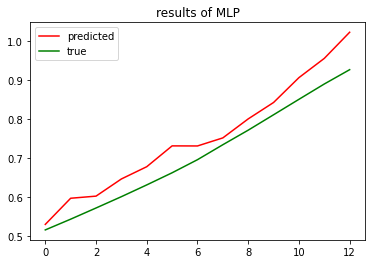

In [ ]:
y_test_pre_mlp = predict(model_MLP, y_test)
print("MLP RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_mlp)
RMSE_mlp.append(rmse)
MAE_mlp.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_mlp, "results of MLP")

In [ ]:
model_LSTM = model_lstm()
fit(model_LSTM, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 3s 209ms/step - loss: 0.0446 - val_loss: 0.7419
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0492 - val_loss: 0.7041
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0533 - val_loss: 0.6749
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0546 - val_loss: 0.6511
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0538 - val_loss: 0.6297
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0519 - val_loss: 0.6084
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0496 - val_loss: 0.5857
Epoch 8/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0472 - val_loss: 0.5599
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0448 - val_loss: 0.5296
Epoch 10/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0425 - val_loss: 0.4929
Epoch 11/100
5/5 [=========

LSTM RESULTS
RMSE =  0.26960456
MAE =  0.24480058


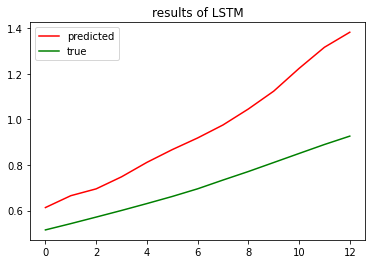

In [ ]:
y_test_pre_lstm = predict(model_LSTM, y_test)
print("LSTM RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_lstm)
RMSE_lstm.append(rmse)
MAE_lstm.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_lstm, "results of LSTM")

In [ ]:
model_GRU = model_gru()
fit(model_GRU, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 3s 195ms/step - loss: 0.0413 - val_loss: 0.7392
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0553 - val_loss: 0.7079
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0591 - val_loss: 0.6869
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0553 - val_loss: 0.6702
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0474 - val_loss: 0.6532
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0382 - val_loss: 0.6325
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0304 - val_loss: 0.6010
Epoch 8/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0256 - val_loss: 0.5604
Epoch 9/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0244 - val_loss: 0.5178
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0202 - val_loss: 0.4731
Epoch 11/100
5/5 [=========

GRU RESULTS
RMSE =  0.03165576
MAE =  0.02949378


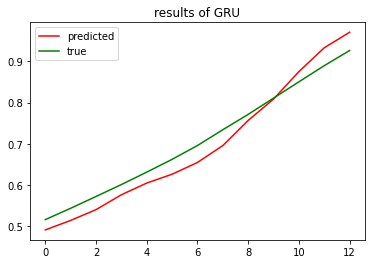

In [ ]:
y_test_pre_gru = predict(model_GRU, y_test)
print("GRU RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_gru)
RMSE_gru.append(rmse)
MAE_gru.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_gru, "results of GRU")


# Uttar Pradesh

In [ ]:
X_train,X_test, y_train, y_test = prepare(df_UP, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
model_CNN = model_cnn()
fit(model_CNN, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 1s 59ms/step - loss: 0.0820 - val_loss: 0.7314
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0691 - val_loss: 0.6380
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0608 - val_loss: 0.5469
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0547 - val_loss: 0.4572
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0455 - val_loss: 0.3677
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0427 - val_loss: 0.2800
Epoch 7/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0394 - val_loss: 0.1979
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0410 - val_loss: 0.1322
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0368 - val_loss: 0.0857
Epoch 10/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0365 - val_loss: 0.0495
Epoch 11/100
5/5 [==========

CNN RESULTS
RMSE =  0.0389462
MAE =  0.028493


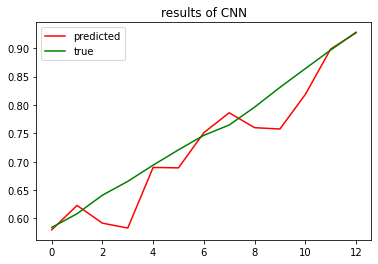

In [ ]:
y_test_pre_cnn = predict(model_CNN, y_test)
print("CNN RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn)
RMSE_cnn.append(rmse)
MAE_cnn.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn, "results of CNN")

In [ ]:
model_MLP = model_mlp()
fit(model_MLP, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 1s 48ms/step - loss: 0.0616 - val_loss: 0.5973
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0604 - val_loss: 0.5867
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0597 - val_loss: 0.5789
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0591 - val_loss: 0.5711
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0585 - val_loss: 0.5628
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0578 - val_loss: 0.5543
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0573 - val_loss: 0.5457
Epoch 8/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0567 - val_loss: 0.5371
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0561 - val_loss: 0.5285
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0555 - val_loss: 0.5202
Epoch 11/100
5/5 [=========

MLP RESULTS
RMSE =  0.0551385
MAE =  0.046122722


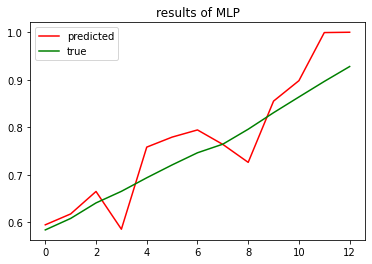

In [ ]:
y_test_pre_mlp = predict(model_MLP, y_test)
print("MLP RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_mlp)
RMSE_mlp.append(rmse)
MAE_mlp.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_mlp, "results of MLP")

In [ ]:
model_LSTM = model_lstm()
fit(model_LSTM, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 3s 201ms/step - loss: 0.0542 - val_loss: 0.5793
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0542 - val_loss: 0.5203
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0550 - val_loss: 0.4609
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0549 - val_loss: 0.3994
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0540 - val_loss: 0.3341
Epoch 6/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0525 - val_loss: 0.2666
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0505 - val_loss: 0.1988
Epoch 8/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0478 - val_loss: 0.1387
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0419 - val_loss: 0.0941
Epoch 10/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0317 - val_loss: 0.0767
Epoch 11/100
5/5 [========

LSTM RESULTS
RMSE =  0.023254726
MAE =  0.019920524


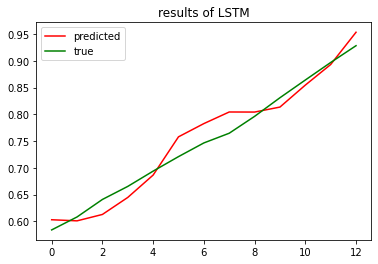

In [ ]:
y_test_pre_lstm = predict(model_LSTM, y_test)
print("LSTM RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_lstm)
RMSE_lstm.append(rmse)
MAE_lstm.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_lstm, "results of LSTM")

In [ ]:
model_GRU = model_gru()
fit(model_GRU, X_train, X_test, y_train, y_test)

Epoch 1/100
5/5 [==============================] - 3s 190ms/step - loss: 0.0630 - val_loss: 0.7401
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0758 - val_loss: 0.6594
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0795 - val_loss: 0.5897
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0787 - val_loss: 0.5277
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0754 - val_loss: 0.4708
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0694 - val_loss: 0.4165
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0613 - val_loss: 0.3633
Epoch 8/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0509 - val_loss: 0.3094
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0385 - val_loss: 0.2533
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0249 - val_loss: 0.1995
Epoch 11/100
5/5 [=========

GRU RESULTS
RMSE =  0.0218837
MAE =  0.018456776


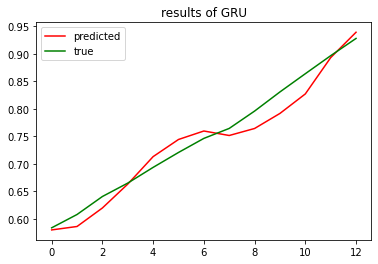

In [ ]:
y_test_pre_gru = predict(model_GRU, y_test)
print("GRU RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_gru)
RMSE_gru.append(rmse)
MAE_gru.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_gru, "results of GRU")


# Comparison

In [ ]:
compare = pd.DataFrame()
compare["State"] = states
compare["rmse_mlp"] = RMSE_mlp
compare["rmse_lstm"] = RMSE_lstm
compare["rmse_gru"] = RMSE_gru
compare["rmse_cnn"] = RMSE_cnn
compare["mae_mlp"] = MAE_mlp
compare["mae_lstm"] = MAE_lstm
compare["mae_gru"] = MAE_gru
compare["mae_cnn"] = MAE_cnn


In [ ]:
compare = compare.round(4)
compare.head()

,State,rmse_mlp,rmse_lstm,rmse_gru,rmse_cnn,mae_mlp,mae_lstm,mae_gru,mae_cnn
0,Maharashtra,0.7947,0.0429,0.1000,0.0497,0.7888,0.0409,0.0990,0.0392
1,Karnataka,0.0567,0.2655,0.0359,0.0905,0.0415,0.2387,0.0332,0.0752
2,Kerala,0.0461,0.0907,0.0506,0.0382,0.0414,0.0832,0.0458,0.0328
3,Tamil Nadu,0.0504,0.2696,0.0317,0.0863,0.0454,0.2448,0.0295,0.0769
4,Uttar Pradesh,0.0551,0.0233,0.0219,0.0389,0.0461,0.0199,0.0185,0.0285


In [ ]:
compare.mean(axis=0)

rmse_mlp     0.20060
rmse_lstm    0.13840
rmse_gru     0.04802
rmse_cnn     0.06072
mae_mlp      0.19264
mae_lstm     0.12550
mae_gru      0.04520
mae_cnn      0.05052
dtype: float64

# RMSE Radar Chart

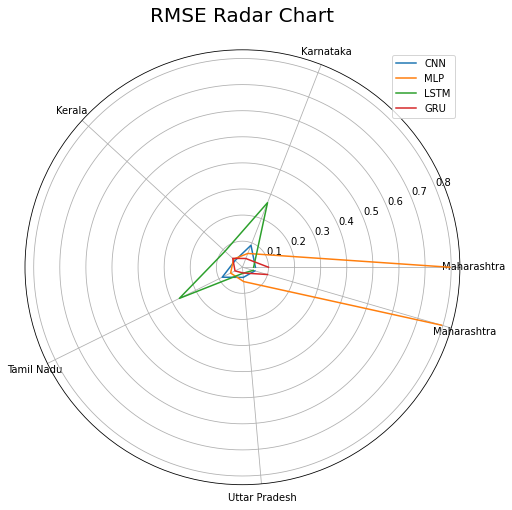

In [ ]:
categories = states
categories = [*categories, categories[0]]

CNN = RMSE_cnn
MLP = RMSE_mlp
LSTM = RMSE_lstm
GRU = RMSE_gru
CNN = [*CNN, CNN[0]]
MLP = [*MLP, MLP[0]]
LSTM = [*LSTM, LSTM[0]]
GRU = [*GRU, GRU[0]]

label_loc = np.linspace(start=0, stop=6, num=len(CNN))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, CNN, label='CNN')
plt.plot(label_loc, MLP, label='MLP')
plt.plot(label_loc, LSTM, label='LSTM')
plt.plot(label_loc, GRU, label='GRU')
plt.title('RMSE Radar Chart', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

# MAE Radar Chart

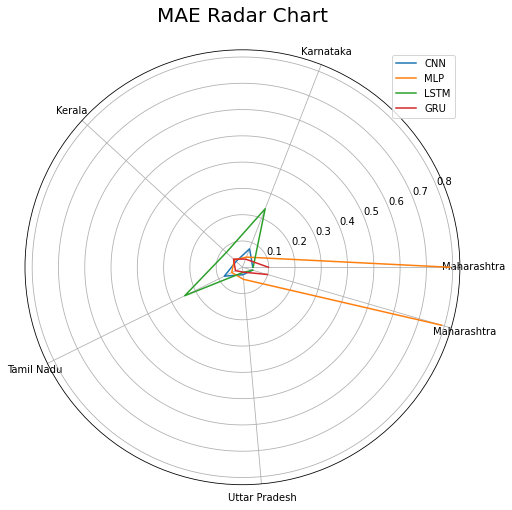

In [ ]:
CNN = MAE_cnn
MLP = MAE_mlp
LSTM = MAE_lstm
GRU = MAE_gru
CNN = [*CNN, CNN[0]]
MLP = [*MLP, MLP[0]]
LSTM = [*LSTM, LSTM[0]]
GRU = [*GRU, GRU[0]]

label_loc = np.linspace(start=0, stop=6, num=len(CNN))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, CNN, label='CNN')
plt.plot(label_loc, MLP, label='MLP')
plt.plot(label_loc, LSTM, label='LSTM')
plt.plot(label_loc, GRU, label='GRU')
plt.title('MAE Radar Chart', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()